101.19405889511108


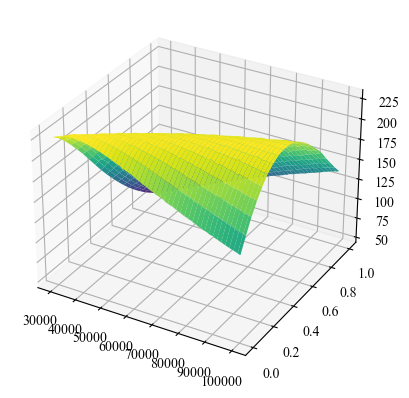

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
from scipy.constants import g
import numpy as np
from math import *
from multiprocessing import Pool, Manager, RawArray
plt.rcParams['font.family'] = ['Times New Roman', 'SimSun']
from time import time

t0=time()
m_f = 4866;
mu_l = 1165.992;
lambda_i = 167.8395;
k = 80000;
rho = 1025;
R_f = 1;
f = 4890;
omega = 2.2143;
m_z = 2433;
tp2 = rho*g*pi*R_f**2

def fun(t, x, eta_i, alpha):
    tp = x[1]-x[3];
    tp = eta_i*tp*abs(tp)**alpha
    return [
	  x[1],
	  (f*cos(omega*t)-tp-lambda_i*x[1]-k*(x[0]-x[2])-tp2*x[0])/(m_f+mu_l),
	  x[3],
	  (tp-k*(x[2]-x[0]))/m_z
	]

y0 = [0, 0, 0, 0]
PTO = np.zeros(shape=(21, 141))
eta_i = 0

def cl(e_i, a_i):
    global eta_i, alpha
    eta_i = e_i*500+30000
    alpha = a_i*0.05
    y = solve_ivp(lambda x,t:fun(x,t,eta_i,alpha), (0, 400), y0, t_eval=np.arange(0, 400, .2)).y
    delta_v = y[1, 999:1999] - y[3, 999:1999];
    pto = eta_i*abs(delta_v)**(2+alpha)
    pp[a_i*141+e_i] = np.trapz(pto)*0.001

def pint(PTO):
    global pp
    pp = PTO

ars = RawArray('d', PTO.ravel())
p = Pool(processes=16, initializer=pint, initargs=(ars,))
for a_i in range(21):
    for e_i in range(141):
        p.apply_async(func=cl, args=(e_i, a_i))

p.close()
p.join()
PTO = np.frombuffer(ars, np.double).reshape(PTO.shape)
print(time()-t0)
x = range(30000, 100001, 500)
y = np.arange(0, 1.01, .05)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(X, Y, PTO, cmap='viridis')
plt.show()
